# Predicting Cointegrated Cryptocurrency Spreads with Long Short Term Memory (LSTM)

**Question:**
Can Long Short Term Memory (LSTM) neural networks surpass the performance of a baseline persistence forecast model in predicting the spread of cointegrated cryptocurrency pairs on the basis of historical price data alone?

**Steps:**
-  Import data: load cryptocurrency data
-  Explore data: plot price movement, returns, correlations between returns
-  Train-test split
-  Find cointegrated cryptocurrency pairs, calculate the spread, and test for stationarity
-  Transform spread series to supervised format for training of LSTM
-  Baseline model: test performance of baseline persistence forecast on the spread series for one crypto pair
-  Initial LSTM implementation (before hyperparameter tuning)
-  LSTM training and tuning: tune hyperparameters using time series cross validation and grid search.
-  Model evaluation: evaluate performance of LSTM model on test data. 

# Import data

Load cryptocurrency price data (downloaded from https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/version/13)

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Import each data into pandas series. Specific cryptocurrencies chosen to ensure sufficient historical data and 
#a sufficient number of possible cointegrated pairs.
Bitcoin = pd.read_csv('cryptocurrencypricehistory/bitcoin_price.csv')
Bitcoin_close = pd.Series(Bitcoin['Close'], name='Bitcoin_close')
Ethereum = pd.read_csv('cryptocurrencypricehistory/ethereum_price.csv')
Ethereum_close = pd.Series(Ethereum['Close'], name='Ethereum_close')
Litecoin = pd.read_csv('cryptocurrencypricehistory/litecoin_price.csv')
Litecoin_close = pd.Series(Litecoin['Close'], name='Litecoin_close')
Dash = pd.read_csv('cryptocurrencypricehistory/dash_price.csv')
Dash_close = pd.Series(Dash['Close'], name='Dash_close')
Monero = pd.read_csv('cryptocurrencypricehistory/monero_price.csv')
Monero_close = pd.Series(Monero['Close'], name='Monero_close')
Nem = pd.read_csv('cryptocurrencypricehistory/nem_price.csv')
Nem_close = pd.Series(Nem['Close'], name='Nem_close')
Ripple = pd.read_csv('cryptocurrencypricehistory/ripple_price.csv')
Ripple_close = pd.Series(Ripple['Close'], name='ripple_close')

#Assemble different price series into dataframe
Cryptos = pd.concat([Bitcoin_close, Ethereum_close, Litecoin_close, Dash_close, Monero_close, Nem_close, Ripple_close], axis=1, names=['Bitcoin', 'Ethereum', 'Litecoin', 'Dash', 'Monero', 'Nem', 'Ripple'])

#Find earliest date back to which price data exists for all columns
num_days =929 
Cryptos = Cryptos[0:num_days]

#Set datetime index
dates = pd.date_range(start='8/7/2015', end='2/20/2018')
dates = pd.Index(reversed(dates))
Cryptos = Cryptos.set_index(dates)

# Data exploration

Examine most recent five days of closing price data. 

In [100]:
Cryptos.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2018-02-20,11403.7,895.37,232.85,685.04,304.40,0.484397,1.09
2018-02-19,11225.3,943.87,223.06,728.73,316.49,0.529261,1.14
2018-02-18,10551.8,923.92,215.74,689.28,300.12,0.530407,1.12
2018-02-17,11112.7,974.12,229.47,742.16,325.67,0.598880,1.20
2018-02-16,10233.9,944.21,230.12,698.86,296.48,0.568887,1.14


Examine first five days of closing price data. 

In [101]:
Cryptos.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2015-08-11,270.39,1.070000,4.16,3.16,0.603582,0.000135,0.008591
2015-08-10,264.47,0.708448,3.95,3.08,0.656576,0.000135,0.008750
2015-08-09,265.08,0.701897,3.90,3.11,0.674739,0.000130,0.008808
2015-08-08,261.00,0.753325,3.85,3.08,0.676046,0.000136,0.008476
2015-08-07,279.58,2.770000,4.21,3.26,0.742292,0.000145,0.008152


Summary statistics of data frame. 

In [102]:
Cryptos.describe()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,2480.192842,147.784327,32.648611,146.184101,48.952522,0.125104,0.167626
std,3802.251587,264.130846,62.084714,268.316629,93.518276,0.269597,0.415997
min,210.500000,0.434829,2.630000,2.060000,0.366891,0.000086,0.004090
25%,435.120000,7.910000,3.610000,6.230000,0.910537,0.001365,0.006291
50%,735.600000,12.020000,3.970000,11.450000,8.420000,0.005415,0.007758
75%,2589.600000,245.990000,42.240000,178.510000,45.020000,0.182819,0.194124
max,19497.400000,1396.420000,358.340000,1550.850000,469.200000,1.840000,3.380000


Plot historical price data for all seven cryptocurrencies.

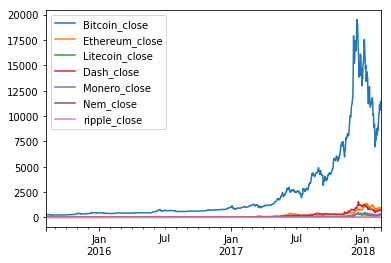

In [103]:
Cryptos = Cryptos[::-1] #Ensures that time is increasing from left to right in plot
Cryptos.plot()

Examine data after July 2017 where there seems to be more activity. 

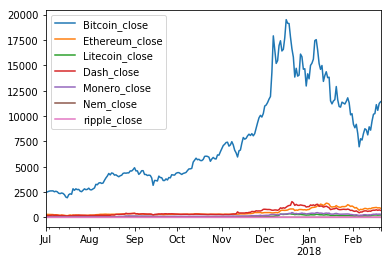

In [104]:
Cryptos_trunc = Cryptos['2017-07-1':'2018-02-20']
Cryptos_trunc.plot()

Normalize all series by their initial values to compare cumulative returns.

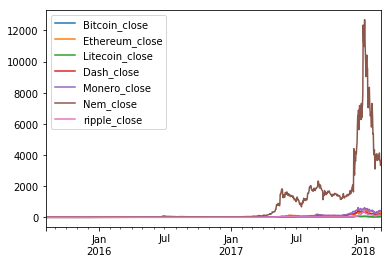

In [105]:
Cryptos_norm = Cryptos/Cryptos.iloc[0]
Cryptos_norm.plot()

Focus on cumulative returns after July 2017.

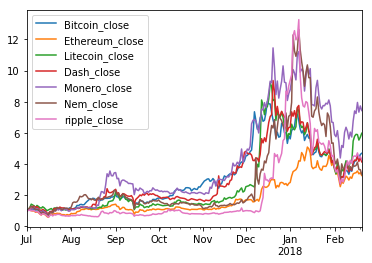

In [106]:
Cryptos_trunc_norm = Cryptos_trunc/Cryptos_trunc.iloc[0]
Cryptos_trunc_norm.plot()

**Observations:** Strong comovement of cumulative returns. Suggests suitability for cointegration. In mid-December 2017, there is a large jump in all cryptos. 

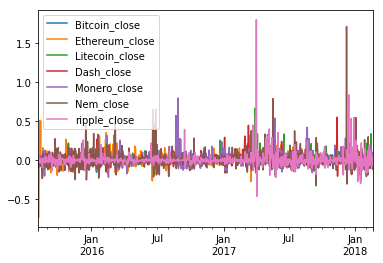

In [107]:
# Calculate returns
Cryptos_returns = Cryptos.pct_change()

#Plot returns
Cryptos_returns.plot()

**Observations:** Volatility fluctuates over time.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23286278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2344c390>]], dtype=object)

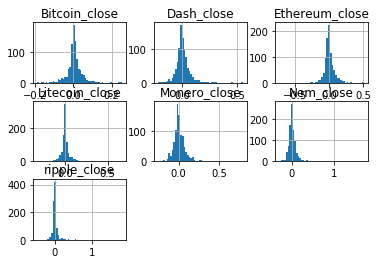

In [108]:
Cryptos_returns = Cryptos_returns.dropna()
Cryptos_returns.hist(bins=50)


In [109]:
Cryptos_returns.corr()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
Bitcoin_close,1.000000,0.283372,0.501214,0.348051,0.376974,0.266718,0.172135
Ethereum_close,0.283372,1.000000,0.258828,0.272124,0.266576,0.177157,0.107364
Litecoin_close,0.501214,0.258828,1.000000,0.311687,0.304474,0.294965,0.244473
Dash_close,0.348051,0.272124,0.311687,1.000000,0.366513,0.218416,0.087201
Monero_close,0.376974,0.266576,0.304474,0.366513,1.000000,0.193071,0.148833
Nem_close,0.266718,0.177157,0.294965,0.218416,0.193071,1.000000,0.178553
ripple_close,0.172135,0.107364,0.244473,0.087201,0.148833,0.178553,1.000000


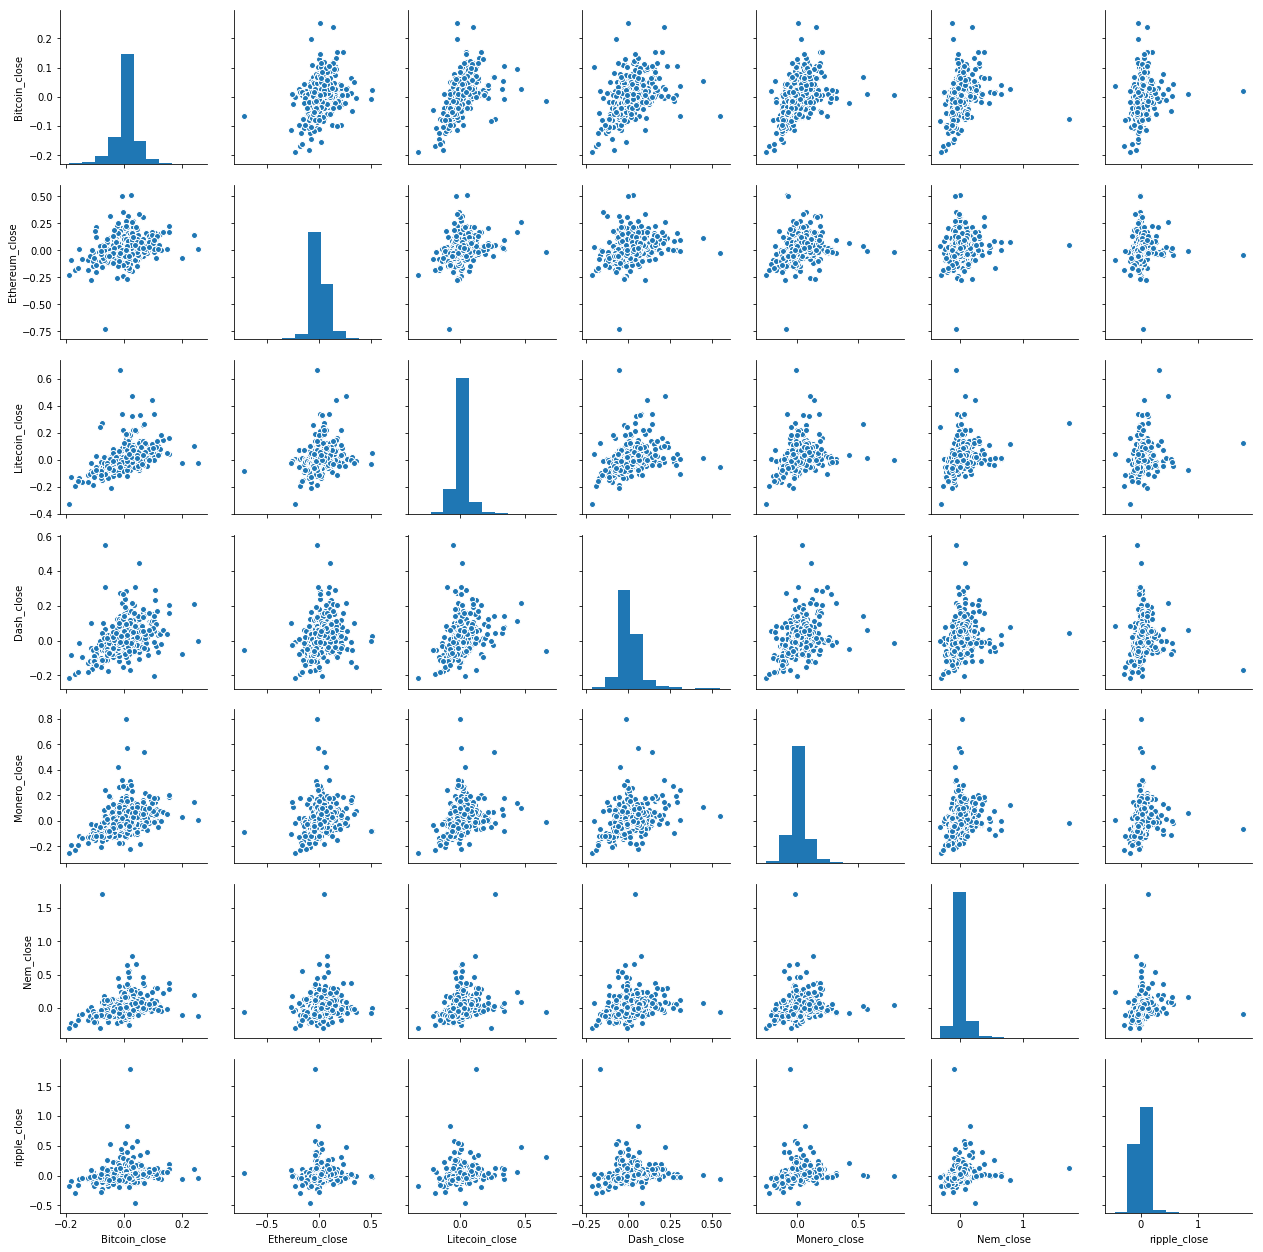

In [110]:
import seaborn as sns

sns.pairplot(Cryptos_returns);

**Observations:** Strong correlations between returns of different pairs of cryptos - e.g., Bitcoin/Litecoin, Monero/Bitcoin

# Train-test split

To allow for the possibility of training a stateful LSTM, the train set must be evenly divisible by batch size. Make train set size an evenly divisible number - e.g., 800 - with many factors to facilitate multiple possible choices of batch size in training. 

In [111]:
X = Cryptos.values
#n_obs = len(X)
#frac = 0.9
#train_size = int(n_obs * frac)
train_size = 800 
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
Cryptos.reindex(index=Cryptos.index[::-1])
Cryptos_train = Cryptos[:train_size]
Cryptos_test = Cryptos[train_size:]

Observations: 929
Training Observations: 800
Testing Observations: 129


Shape check. 

In [112]:
Cryptos_train.shape

(800, 7)

In [113]:
Cryptos_test.shape

(129, 7)

In [114]:
Cryptos_train.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2015-08-07,279.58,2.770000,4.21,3.26,0.742292,0.000145,0.008152
2015-08-08,261.00,0.753325,3.85,3.08,0.676046,0.000136,0.008476
2015-08-09,265.08,0.701897,3.90,3.11,0.674739,0.000130,0.008808
2015-08-10,264.47,0.708448,3.95,3.08,0.656576,0.000135,0.008750
2015-08-11,270.39,1.070000,4.16,3.16,0.603582,0.000135,0.008591


In [115]:
Cryptos_train.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2017-10-10,4781.99,299.87,50.72,291.27,86.82,0.209909,0.260733
2017-10-11,4826.48,303.46,50.89,298.40,87.42,0.214811,0.264439
2017-10-12,5446.91,304.14,60.11,291.91,87.09,0.206147,0.248414
2017-10-13,5647.21,338.76,59.43,310.38,95.13,0.211569,0.260489
2017-10-14,5831.79,339.63,63.95,316.69,100.23,0.210581,0.257320


In [116]:
Cryptos_test.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2017-10-15,5678.19,336.60,65.47,309.51,94.87,0.207300,0.263983
2017-10-16,5725.59,333.38,64.62,302.21,95.90,0.223181,0.256232
2017-10-17,5605.51,317.08,59.48,299.88,91.28,0.218207,0.232064
2017-10-18,5590.69,314.32,60.73,297.26,89.54,0.220316,0.218520
2017-10-19,5708.52,308.09,59.74,295.47,88.62,0.220531,0.215150


In [117]:
Cryptos_test.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2018-02-16,10233.9,944.21,230.12,698.86,296.48,0.568887,1.14
2018-02-17,11112.7,974.12,229.47,742.16,325.67,0.598880,1.20
2018-02-18,10551.8,923.92,215.74,689.28,300.12,0.530407,1.12
2018-02-19,11225.3,943.87,223.06,728.73,316.49,0.529261,1.14
2018-02-20,11403.7,895.37,232.85,685.04,304.40,0.484397,1.09


Put test set aside. Focus on training data.

# Find cointegrated series, compute the spread, test for stationarity

Find cointegrated pairs of cryptocurrencies using function that inputs dataframe whose columns are closing price data for different cryptocurrencies and outputs matrix of scores, pvalues, and a list of cointegrated pairs. Loop through all $n^{2}$ pairs, use statsmodels _coint_ function to calculate score (t-statistic), and p value for each pair. Cointegrated pairs are those for which the p value lies below some specified threshold. The function *find_cointegrated_pairs* is adapted from the Quantopian lectures on pairs trading (https://www.quantopian.com/lectures/introduction-to-pairs-trading).

In [118]:
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.001:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [119]:
score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(Cryptos_train)

In [120]:
score_matrix

array([[  0.00000000e+00,  -1.65232439e+00,  -2.91271762e+00,
         -4.05039811e+00,  -4.88841340e+00,   2.99146629e-04,
         -7.24545641e-01],
       [  0.00000000e+00,   0.00000000e+00,  -6.28563525e+00,
         -3.89012568e+00,  -3.33461078e+00,  -6.23039729e+00,
         -4.09982825e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -2.90230118e+00,  -3.14028033e+00,  -5.38490019e+00,
         -2.57998085e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -4.27807513e+00,  -2.83077643e+00,
         -1.95933742e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -2.56490520e+00,
         -2.33730254e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -2.88924182e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00

In [121]:
pvalue_matrix

array([[  1.00000000e+00,   6.98308024e-01,   1.32436899e-01,
          6.07813179e-03,   2.62664144e-04,   9.85907205e-01,
          9.43923971e-01],
       [  1.00000000e+00,   1.00000000e+00,   3.83293552e-07,
          1.02349719e-02,   5.01500028e-02,   5.08611067e-07,
          5.14768774e-03],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.35291970e-01,   8.04955355e-02,   3.03797490e-05,
          2.44977715e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.76941029e-03,   1.56088522e-01,
          5.49639337e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.51217688e-01,
          3.55094282e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.38933365e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00

In [122]:
pairs

[('Bitcoin_close', 'Monero_close'),
 ('Ethereum_close', 'Litecoin_close'),
 ('Ethereum_close', 'Nem_close'),
 ('Litecoin_close', 'Nem_close')]

Check the spread series of identified pairs for stationarity using the augmented Dickey-Fuller test.

p-value = 4.037278103e-07 The series Bitcoin_close/Monero_close spread is likely stationary.


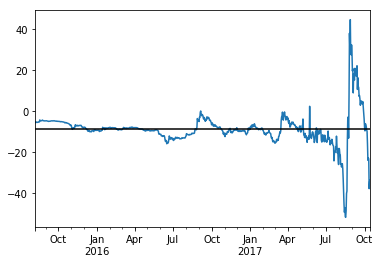

p-value = 8.42014509346e-09 The series Ethereum_close/Litecoin_close spread is likely stationary.


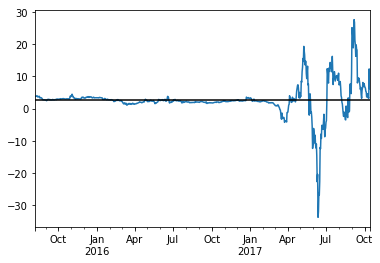

p-value = 2.30227481647e-09 The series Ethereum_close/Nem_close spread is likely stationary.


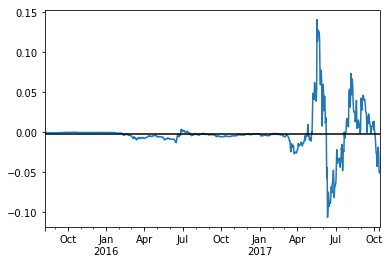

p-value = 6.20826943592e-07 The series Litecoin_close/Nem_close spread is likely stationary.


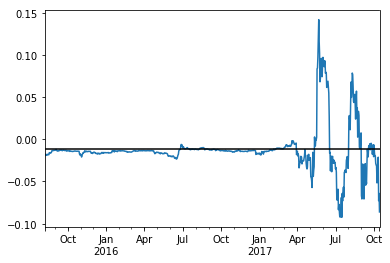

In [123]:
def check_for_stationarity(X, cutoff=0.001):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + str(X.name) +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + str(X.name) +' is likely non-stationary.')
        return False

spreads_train = [] #Collect spreads of cointegrated pairs in training set
spreads_train_OLSparams = []

for pair in pairs:
    S1 = Cryptos_train[pair[0]]
    S2 = Cryptos_train[pair[1]]
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[pair[0]]
    b = results.params[pair[0]]

    spread = S2 - b * S1
    spread.name = pair[0] + '/' + pair[1] + ' spread'
    if check_for_stationarity(spread):
        spreads_train.append(spread)
        spreads_train_OLSparams.append(results)
        
    spread.plot()
    plt.axhline(spread.mean(), color='black')
    plt.show()
    
    

**Observation:** Dramatic increase in volatility in all the spreads starting at around April 2017. 

Check spreads in spreads_train, and parameters in spreads_train_OLSparams:

In [124]:
#Check spreads in spreads_train
print("Check spreads in spreads_train: ")
for spread in spreads_train:
    print(spread.name)

print("")
#Check spreads_train
print("OLS parameters: ")
for results in spreads_train_OLSparams:
    print(results.params[0], results.params[1])  

#Use Ethereum Litecoin spread, called spreads[]
spread_train_EL = spreads_train[1]

Check spreads in spreads_train: 
Bitcoin_close/Monero_close spread
Ethereum_close/Litecoin_close spread
Ethereum_close/Nem_close spread
Litecoin_close/Nem_close spread

OLS parameters: 
-8.83504772781 0.0229645286619
2.69404132329 0.157314049108
-0.00200413266628 0.000769941085293
-0.0120331397842 0.00464095645024


[('Bitcoin_close', 'Monero_close'), ('Ethereum_close', 'Litecoin_close'), ('Ethereum_close', 'Nem_close'), ('Litecoin_close', 'Nem_close')]


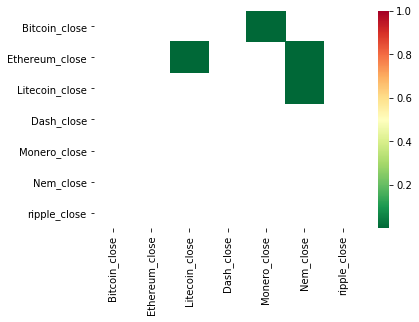

In [125]:
import seaborn
seaborn.heatmap(pvalue_matrix, xticklabels=Cryptos_train.columns, yticklabels=Cryptos_train.columns, cmap='RdYlGn_r' 
                , mask = (pvalue_matrix >= 0.001)
                )
print(pairs)

Color indicates strength of the cointegration relationship. Ethereum/Litecoin has smallest p-value. Focus on this spread in analysis below. 

# Transform spread series for training of LSTM 

Perform three transformations of data: differencing, conversion to supervised format, and scaling. Code adapted from Jason Brownlee's  https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/. 

In [131]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler

#frame time series as a supervised learning problem, with 
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

#create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

#invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
#scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
#inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


#compute Ethereum-Litecoin spread on full data set using OLS parameters found from regression on training set.
U1 = Cryptos['Ethereum_close']
U2 = Cryptos['Litecoin_close']
b = spreads_train_OLSparams[1].params['Ethereum_close']
spread_EL = U2 - b*U1

#split spread series into train and test for evaluation of baseline model and LSTM model. 
train = spread_EL.values[:train_size]
test = spread_EL.values[train_size:]

#difference spread series data
differenced = difference(spread_EL.values)

#transform differenced spread series for supervised learning. features consist of lagged values of spread series.
#label is spread series at next time. window gives number of lags. 
window = 5
supervised = timeseries_to_supervised(differenced, window)

#split supervised data into train and test-sets
train_supervised, test_supervised = supervised.values[0:train_size], supervised.values[train_size:]

#transform scale of differenced, supervised data for LSTM training
scaler, train_supervised_scaled, test_supervised_scaled = scale(train_supervised, test_supervised)

#SMOOTH TRAINING DATA - USE THIS FOR TRAINING LSTM SO THAT IT DOESN'T LEARN NOISE
#smooth full series
spread_EL_smoothed = differenced.rolling(5).mean()

# transform smoothed data for supervised learning
supervised_smoothed = timeseries_to_supervised(spread_EL_smoothed.values, window)
supervised_smoothed = supervised_smoothed.values
print("supervised_smoothed.shape: " + str(supervised_smoothed.shape))

#split supervised smoothed set into train and test
train_supervised_smoothed = supervised_smoothed[:train_size]
test_supervised_smoothed = supervised_smoothed[train_size:]
print("train_supervised_smoothed.shape: " + str(train_supervised_smoothed.shape))

# transform the scale of the supervised smoothed data for LSTM training
scaler, train_supervised_smoothed_scaled, test_supervised_smoothed_scaled = scale(train_supervised_smoothed, test_supervised_smoothed)
print("train_supervised_smoothed_scaled.shape: " + str(train_supervised_smoothed_scaled.shape))

#split smoothed train set into lagged values or features (X) and labels (y)
train_supervised_smoothed_scaled_X = train_supervised_smoothed_scaled[:,0:-1]
train_supervised_smoothed_scaled_y = train_supervised_smoothed_scaled[:,-1]
print("train_supervised_smoothed_scaled_X.shape: " + str(train_supervised_smoothed_scaled_X.shape))
print("train_supervised_smoothed_scaled_y.shape: " + str(train_supervised_smoothed_scaled_y.shape))

supervised_smoothed.shape: (928, 6)
train_supervised_smoothed.shape: (800, 6)
train_supervised_smoothed_scaled.shape: (800, 6)
train_supervised_smoothed_scaled_X.shape: (800, 5)
train_supervised_smoothed_scaled_y.shape: (800,)


# Baseline model: compute RMSE for persistence forecast

RMSE: 14.353


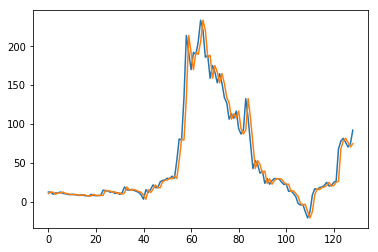

In [135]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
#report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
#line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

**The number to beat:**  RMSE = 14.353

## Initial LSTM implementation (before hyperparameter tuning)

Functions for defining, training, and forecasting with LSTM model. 

In [139]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from math import sqrt

#create lstm model
def create_model(input_shape, optimizer='adam', dropout_rate=0.0, loss='mean_squared_error', layers=(32,32,1)):
    # create model
    model = Sequential()
    model.add(LSTM(layers[0], input_shape=(input_shape[0],input_shape[1]), stateful=False, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(layers[1],return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("linear"))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
    return model

#fit LSTM network to training data
def fit_lstm(train, batch_size, num_epochs, layers, dropout_rate):
    X_train, y_train = train[:, 0:-1], train[:, -1]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    input_shape = (X_train.shape[1], 1)
    model = create_model(input_shape, dropout_rate=dropout_rate, layers=layers)
    for i in range(num_epochs):
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        #model.reset_states()
    return model

#make a one-step forecast
def forecast_lstm(model, batch_size, row):
    row = row.reshape(1, len(row), 1)
    yhat = model.predict(row, batch_size=batch_size)
    return yhat[0 ,0]

Test performance of model on initial set of parameters: training epochs = 10; dropout = 2.0; 32 neurons in first hidden layer, 32 in second hidden layer, 1 in output layer; batch size = 200.

(800, 5)
(800, 1)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


(128, 6, 1)
expected.shape: (127,)
predictions.shape: (127,)
Test RMSE: 14.316


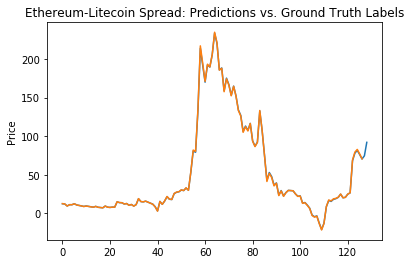

In [140]:
#initial implementation 
num_epochs = 10
dropout_rate = .2
layers = (32, 32, 1)
batch_size = 200
#optimizer = 'adam'
#loss = 'mean_squared_error'

#prepare scaled, smoothed, supervised data for fitting of LSTM model
train_supervised_smoothed_scaled_y = train_supervised_smoothed_scaled_y.reshape((train_supervised_smoothed_scaled_y.shape[0],1))
train = np.concatenate((train_supervised_smoothed_scaled_X, train_supervised_smoothed_scaled_y), axis=1)

#fit lstm model
model = fit_lstm(train, batch_size, num_epochs, layers, dropout_rate)

#test 
test_supervised_scaled = test_supervised_scaled.reshape((test_supervised_scaled.shape[0], test_supervised_scaled.shape[1], 1))
print(test_supervised_scaled.shape)

input_shape = (test_supervised_scaled.shape[1]-1, test_supervised_scaled.shape[2])

#EVALUATE TRAINED MODEL ON TEST DATA
#-----------------------------------------------------------------------------------------------------------------
# walk-forward validation on the test data
predictions = list()
expected = list()
for i in range(len(test_supervised_scaled)-1):
    # make one-step forecast
    X_i, y_i = test_supervised_scaled[i, 0:-1], test_supervised_scaled[i, -1]
    yhat = forecast_lstm(model, 1, X_i)
    # invert scaling
    yhat = invert_scale(scaler, X_i, yhat)
    # invert differencing
    yhat = inverse_difference(spread_EL.values, yhat, len(test_supervised_scaled) + 1 - i)
    # store forecast
    predictions.append(yhat)
    expected.append(spread_EL.values[len(train) + i + 1])
    #print('Test_Day=%d, Predicted=%f, Expected=%f' % ( i+1, yhat, expected))

expected = np.squeeze(expected)
print("expected.shape: " + str(expected.shape))
predictions = np.squeeze(predictions)
print("predictions.shape: " + str(predictions.shape))

# report performance
rmse = sqrt(mean_squared_error(expected, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(spread_EL.values[train_size:])
pyplot.plot(predictions)
pyplot.title("Ethereum-Litecoin Spread: Predictions vs. Ground Truth Labels")
pyplot.ylabel("Price")
pyplot.savefig('ELSpreadLSTM.png')
pyplot.show()

# LSTM training and tuning: tune hyperparameters using time series cross validation (CV) and grid search

-  Perform time series CV 

In [58]:
#function to perform time series cross validation
def TimeSeriesCV(X_train, y_train, num_folds, parameters, scaler, train_raw):
    """
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    Returns mean of test accuracies.
    """
    optimizer = parameters[0]
    dropout_rate = parameters[1]
    loss = parameters[2]
    layers = parameters[3]
    batch_size = parameters[4]
    num_epochs = parameters[5]
    
    input_shape = (X_train.shape[1], 1) #shape of individual samples input into LSTM
    
    print('Parameters --------------------------------> ' + str(parameters))
    print('Size train set: ' + str(X_train.shape))
    
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0])/num_folds))
    print('Size of each fold: ' + str(k))
    
    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    rmse_array = np.zeros(num_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, num_folds + 1):
        print('')
        print('fold: ' + str(i))
        
        #model = create_model(input_shape, optimizer, dropout_rate, loss, layers, batch_size)
        
        split = float(i-1)/i #fraction of set to train on
        
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i)) 
        
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        X = X.reshape((X.shape[0], X.shape[1], 1))
        y = y.reshape((y.shape[0], 1, 1))
        raw_values = train_raw[:(k*i)]
        #raw_values = raw_values.reshape((raw_values.shape[0], raw_values.shape[1], 1))
        print("raw_values.shape: " + str(raw_values.shape))
        #print('X.shape' + str(X.shape))
        #print('y.shape' + str(y.shape))
        #print('Size of train + test: ' + str(X.shape)) # the size of the dataframe is going to be k*i

        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        X_trainFolds = X_trainFolds.reshape((X_trainFolds.shape[0], X_trainFolds.shape[1], 1))
        y_trainFolds = y_trainFolds.reshape((y_trainFolds.shape[0], 1, 1))
        #print("X_trainFolds.shape"+ str(X_trainFolds.shape))
        #print("y_trainFolds.shape"+ str(y_trainFolds.shape))
        trainFolds = np.concatenate((X_trainFolds, y_trainFolds), axis=1)
        #print("trainFolds.shape"+ str(trainFolds.shape))
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        #print("X_testFolds.shape"+ str(X_testFold.shape))
        #print("y_testFolds.shape"+ str(y_testFold.shape))
        
        # i starts from 2 so the zeroth element in accuracies array is i-2. performClassification() is a function 
        # which takes care of a classification problem. This is only an example and you can replace this function with whatever ML approach you need.
        #rmse_list[i-2] = performClassification(X_trainFolds, y_trainFolds, X_testFolds, y_testFolds, algorithm, parameters)
        
        #Fit model
        model_fit = fit_lstm(trainFolds, batch_size, num_epochs, layers, dropout_rate)
        
        #Re-define model w/ batch_size 1 for use w/ stateful LSTM
        weights = model_fit.get_weights()
        # re-define batch size for prediction with model
        batch_size_pred = 1
        new_model = create_model(input_shape, optimizer, dropout_rate, loss, layers)
        new_model.set_weights(weights) 
        
        #Make predictions on validation fold, measure performance
        predictions = list()
        expected = list()
        #total = np.concatenate((X, y), axis=1)
        #total = np.squeeze(total)
        for j in range(len(X_testFold)):
        # make one-step forecast
            X_j, y_j = X_testFold[j], y_testFold[j]
            yhat = forecast_lstm(new_model, 1, X_j)
            #print("yhat: " + str(yhat))
            # invert scaling
            yhat = invert_scale(scaler, X_j, yhat)
            #y_j = invert_scale(scaler, X_j, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(X_testFold) + 1 - j)
            #y_j = inverse_difference(, X_j, y_j)
            # store forecast
            predictions.append(yhat)
            expected.append(raw_values[len(X_trainFolds) + i + 1])
            #print('Month=%d, Predicted=%f, Expected=%f' % ( i+1, yhat, expected))
        
        # report performance
        expected = np.squeeze(expected)
        print("expected.shape: " + str(expected.shape))
        predictions = np.squeeze(predictions)
        print("predictions.shape: " + str(predictions.shape))
        rmse_array[i-2] = sqrt(mean_squared_error(expected, predictions))
        
        print('rmse on fold ' + str(i) + ': ' + str(rmse_array[i-2]))
        
        #Save final weights
        if i == num_folds:
            model_fit_json = model_fit.to_json()
            with open("Models__Capstone10_wARMA_Window_Stacked_Smoothing_TimeSeriesCV-Copy1/TimeSeriesCVArchitecture_epochs" + str(num_epochs) + "_dropout" + str(dropout_rate) + "_layers" + str(layers) +  ".json", "w") as json_file:
                json_file.write(model_fit_json)
            # serialize weights to HDF5
            model_fit.save_weights("Models__Capstone10_wARMA_Window_Stacked_Smoothing_TimeSeriesCV-Copy1/TimeSeriesCVWeights_epochs" + str(num_epochs) + "_dropout" + str(dropout_rate) + "_layers" + str(layers) + ".h5")
            print("Saved model to disk")
    
    # the function returns the mean of the accuracy on the n-1 folds and the model weights  
    return rmse_array.mean(), model_fit.get_weights()


#search different hyperparameters, storing result of time series crossvalidation for each set
def Grid_Search(epochs_list, dropout_rate_list, layers_list, batch_size_list, X_train_scaled, y_train_scaled, num_folds, scaler, train_raw):
    #Store scores and model weights/architectures for different TimeSeriesCV parameters
    scores_models_dict = {} 
    for epochs in epochs_list:
        for rate in dropout_rate_list:
            for layers in layers_list:
                for batch_size in batch_size_list:
                    print("")
                    print("WINDOW: " + str(window) + ", " + "NUM_EPOCHS: " + str(epochs) + ", " + "DROPOUT_RATE: " + str(rate) + ", " + "LAYERS: " + str(layers) + ", " + "BATCH_SIZE: " + str(batch_size))
                    parameters = ['adam', rate, 'mean_squared_error', layers, batch_size, epochs]
                    score, weights = TimeSeriesCV(X_train_scaled, y_train_scaled, num_folds, parameters, scaler, train_raw)
                    scores_models_dict[(epochs, rate, layers, batch_size)] = (score, weights)
                    print("MODEL SCORE: " + str(score))
    #Find max score and corresponding parameters
    scores = [value[0] for value in scores_models_dict.values()]
    weights = [value[1] for value in scores_models_dict.values()]
    
    keys = list(scores_models_dict.keys())
    
    best_score = min(scores)
    best_params = keys[scores.index(best_score)]
    best_weights = weights[scores.index(best_score)]
    
    return best_score, best_params, best_weights, scores_models_dict 
    
    #TimeSeriesCV(train_supervised_smoothed_scaled_X, train_supervised_smoothed_scaled_y, number_folds, parameters, scaler)
    
    
#Hyperparameters to search

epochs_list = [10,20] 
dropout_rate_list = [2.0]
layers_list = [(3,3,1), (5,5,1), (32,32,1)]
batch_size_list = [50, 100, 200]


'''
epochs_list = [10, 20, 30] 
dropout_rate_list = [0.0, 1.0, 2.0]
layers_list = [(64,32,1), (32,32,1)]
'''
 
'''
epochs_list = [2] 
dropout_rate_list = [1.0]
layers_list = [(64,32,1)]
'''
    

number_folds = 4 #TimeSeriesCV number of folds

best_score, best_params, best_weights, scores_models_dict = Grid_Search(epochs_list, dropout_rate_list, layers_list, batch_size_list, train_supervised_smoothed_scaled_X, train_supervised_smoothed_scaled_y, number_folds, scaler, spread_EL.values[:train_size])    

print("")
print("BEST SCORE: " + str(best_score))
print("BEST PARAMS: " + str(best_params))


WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 50, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.596437623824

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.42069243615

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.1788534612
Saved model to disk
MODEL SCORE: 4.06532784039

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 100, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.598867240499

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.41689545573

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2391678326
Saved model to disk
MODEL SCORE: 4.08497684293

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 200, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.591600900673

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.41891645897

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2392559499
Saved model to disk
MODEL SCORE: 4.08325776985

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 50, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.594920700068

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.43633973246

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2483967889
Saved model to disk
MODEL SCORE: 4.09321907382

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 100, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.588738133193

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.41087368845

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2248360317
Saved model to disk
MODEL SCORE: 4.07481595112

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 200, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.603327053012

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.4210141809

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2174946864
Saved model to disk
MODEL SCORE: 4.08061197345

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 50, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.608556872881

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.46399531866

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.5328813379
Saved model to disk
MODEL SCORE: 4.20181117648

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 100, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.602362897847

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.45072505969

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.4653479476
Saved model to disk
MODEL SCORE: 4.17281196839

WINDOW: 5, NUM_EPOCHS: 10, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 200, 10]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.606286914815

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.43745353298

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2691194612
Saved model to disk
MODEL SCORE: 4.10428663632

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 50, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.596649110782

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.44430928726

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.3034717389
Saved model to disk
MODEL SCORE: 4.11481004566

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 100, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.598699932042

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.42682649225

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2958226266
Saved model to disk
MODEL SCORE: 4.10711635031

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (3, 3, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (3, 3, 1), 200, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.593121483236

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.41507857867

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.212345583
Saved model to disk
MODEL SCORE: 4.07351521497

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 50, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.601061190071

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.4665869103

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.495876893
Saved model to disk
MODEL SCORE: 4.18784166447

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 100, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.597261084727

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.44745551107

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2839901163
Saved model to disk
MODEL SCORE: 4.10956890404

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (5, 5, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (5, 5, 1), 200, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.599150802789

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.41713648221

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2498521289
Saved model to disk
MODEL SCORE: 4.08871313796

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 50
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 50, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.611604818696

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.46410888553

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.4283100877
Saved model to disk
MODEL SCORE: 4.16800793065

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 100
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 100, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.601904274987

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.43108778421

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.2337503436
Saved model to disk
MODEL SCORE: 4.08891413427

WINDOW: 5, NUM_EPOCHS: 20, DROPOUT_RATE: 2.0, LAYERS: (32, 32, 1), BATCH_SIZE: 200
Parameters --------------------------------> ['adam', 2.0, 'mean_squared_error', (32, 32, 1), 200, 20]
Size train set: (800, 5)
Size of each fold: 200

fold: 2
Splitting the first 2 chunks at 1/2
raw_values.shape: (400,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 2: 0.595473475806

fold: 3
Splitting the first 3 chunks at 2/3
raw_values.shape: (600,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 3: 1.43626257331

fold: 4
Splitting the first 4 chunks at 3/4
raw_values.shape: (800,)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


expected.shape: (199,)
predictions.shape: (199,)
rmse on fold 4: 10.5674902012
Saved model to disk
MODEL SCORE: 4.19974208345

BEST SCORE: 4.06532784039
BEST PARAMS: (10, 2.0, (3, 3, 1), 50)


## Measure Performance on Test Set

In [59]:
num_epochs = best_params[0]
dropout_rate = best_params[1]
layers = best_params[2]
batch_size = best_params[3]
optimizer = 'adam'
loss = 'mean_squared_error'

test_supervised_scaled = test_supervised_scaled.reshape((test_supervised_scaled.shape[0], test_supervised_scaled.shape[1], 1))
print(test_supervised_scaled.shape)

input_shape = (test_supervised_scaled.shape[1]-1, test_supervised_scaled.shape[2])

best_model = create_model(input_shape, optimizer=optimizer, dropout_rate=dropout_rate, loss=loss, layers=layers)
best_model.set_weights(best_weights)


(128, 6, 1)


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Test RMSE: 14.400


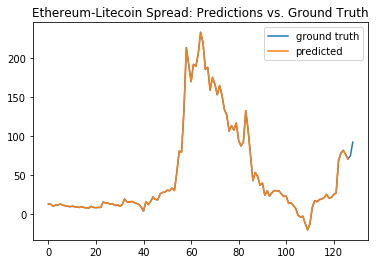

In [60]:
#EVALUATE TRAINED MODEL ON TEST DATA
#-----------------------------------------------------------------------------------------------------------------
# walk-forward validation on the test data
predictions = list()
expected = list()
for i in range(len(test_supervised_scaled)-1):
    # make one-step forecast
    X_i, y_i = test_supervised_scaled[i, 0:-1], test_supervised_scaled[i, -1]
    yhat = forecast_lstm(best_model, 1, X_i)
    # invert scaling
    yhat = invert_scale(scaler, X_i, yhat)
    # invert differencing
    yhat = inverse_difference(spread_EL.values, yhat, len(test_supervised_scaled) + 1 - i)
    # store forecast
    predictions.append(yhat)
    expected.append(spread_EL.values[len(train) + i + 1])
    #print('Test_Day=%d, Predicted=%f, Expected=%f' % ( i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(expected, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(spread_EL.values[train_size:], label = "ground truth")
pyplot.plot(predictions, label = "predicted")
pyplot.title("Ethereum-Litecoin Spread: Predictions vs. Ground Truth")
pyplot.legend()
pyplot.savefig('Test_Set_Results.png')
pyplot.show()